In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import numpy as np
import xarray as xr
import sectionate
import matplotlib.pyplot as plt

In [71]:
#xr.set_options(display_style="text")

# Conservatively diagnosing model transports across arbitrary sections with `sectionate`

## Load example model grid and transport diagnosics

In [72]:
dir_pp = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_test_v6_proto2/gfdl.ncrc4-intel18-prod-openmp/pp/'

In [73]:
grid = xr.open_dataset(f"{dir_pp}/ocean_annual_rho2_d2/ocean_annual_rho2_d2.static.nc")
symmetric = grid['geolon_c'].shape!=grid['geolon'].shape
symmetric

True

In [74]:
ds = xr.open_mfdataset(f"{dir_pp}/ocean_annual_z_d2/av/annual_5yr/*.nc", decode_times=False)
ds = ds.assign_coords({
    'dxCv': xr.DataArray(grid['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)),
    'dyCu': xr.DataArray(grid['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',))
}) # add velocity face widths to calculate distances along the section

## Define the two OSNAP sections:

In [75]:
West_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000]
West_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]

East_section_lats=[60.3000, 58.8600, 58.0500, 58.0000, 56.5000]
East_section_lons=[-44.9000, -30.5400, -28.0000, -14.7000, -5.9300]

## West section

In [76]:
iwest, jwest, xwest, ywest = sectionate.create_section_composite(grid['geolon_c'],
                                                                 grid['geolat_c'],
                                                                 West_section_lons,
                                                                 West_section_lats,
                                                                 symmetric
                                                                )

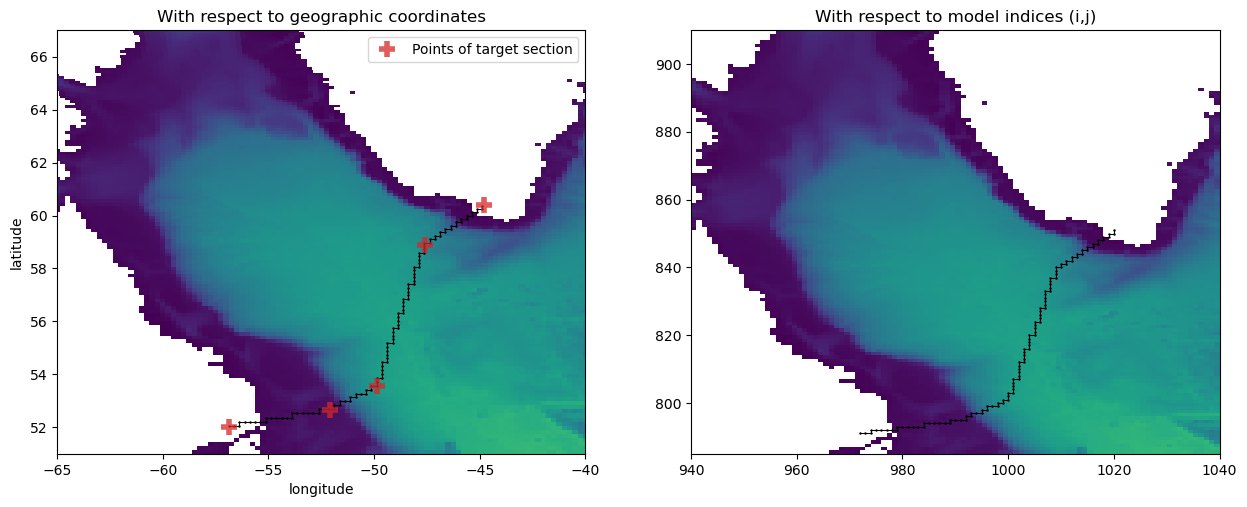

In [77]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(grid['geolon_c'], grid['geolat_c'], grid['deptho'].where(grid['deptho']!=0))
plt.plot(xwest, ywest, 'k.-', markersize=1.5, lw=0.75)
plt.plot(West_section_lons, West_section_lats, "C3+", markersize=12., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-65,-40, 51, 67])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(grid['deptho'].where(grid['deptho']!=0).values)
plt.plot(iwest, jwest, 'k.-', markersize=1.5, lw=0.75)
plt.axis([940, 1040, 785, 910])
plt.title("With respect to model indices (i,j)")
plt.show()

### Plot the hydrography and cell-integrated mass transport across the section

In [78]:
Trp_west = sectionate.convergent_transport(ds, iwest, jwest, symmetric, counterclockwise=True)

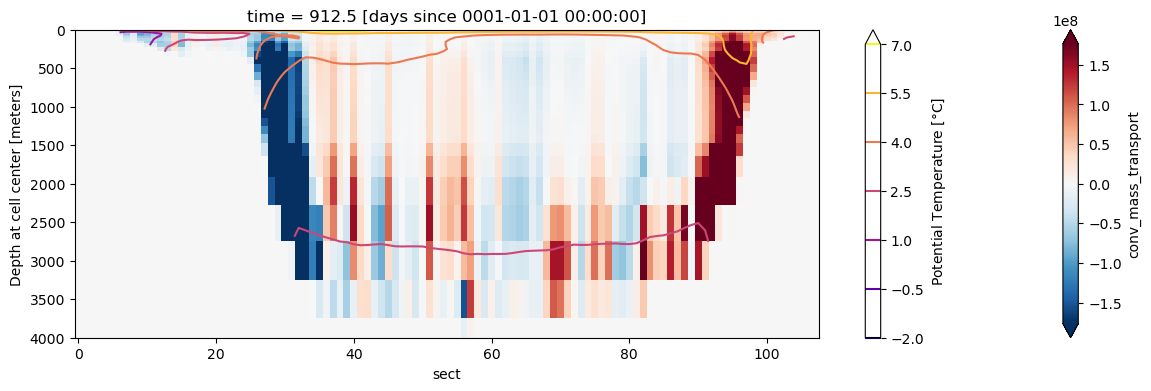

In [79]:
plt.figure(figsize=(15, 4))
Trp_west.isel(time=0)['conv_mass_transport'].swap_dims({'sect':'distance'}).plot(cmap='RdBu_r', x="distance", yincrease=False, ylim=[4000,0], robust=True)
cs = T_west.isel(time=0).plot.contour(vmin=-2, vmax=7, cmap='plasma', yincrease=False, ylim=[4000,0])
plt.colorbar(cs, label=r"Potential Temperature [$\degree$C]")

## East section

In [80]:
ieast, jeast, xeast, yeast = sectionate.create_section_composite(grid['geolon_c'],
                                                                grid['geolat_c'],
                                                                East_section_lons,
                                                                East_section_lats,
                                                                symmetric)

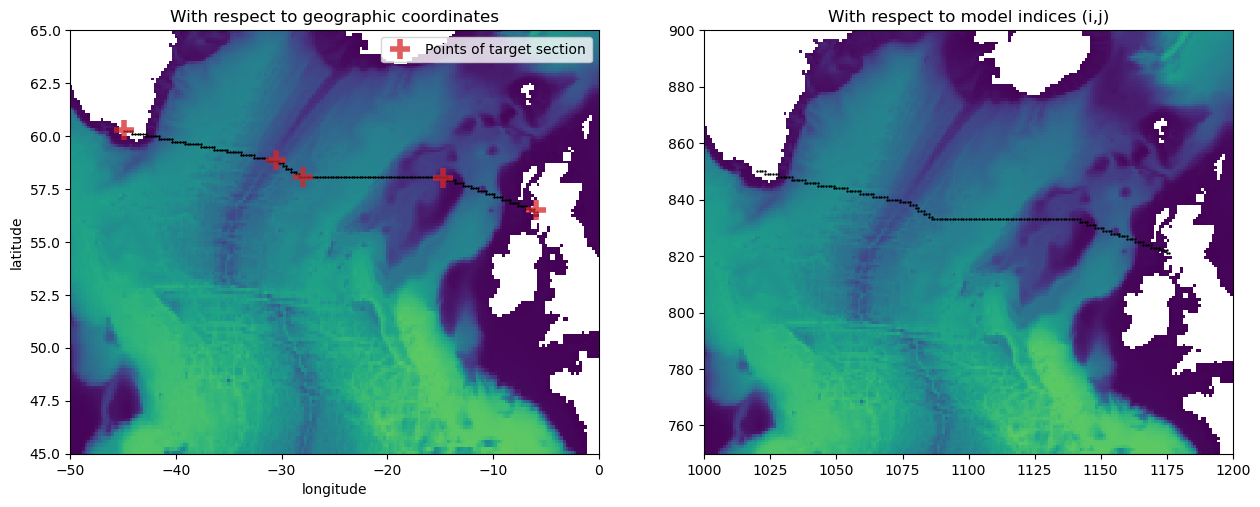

In [81]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(grid['geolon_c'], grid['geolat_c'], grid['deptho'].where(grid['deptho']!=0))
plt.plot(xeast, yeast, 'k.-', markersize=1.5, lw=0.75)
plt.plot(East_section_lons, East_section_lats, "C3+", markersize=15., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-50, 0, 45, 65])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(grid['deptho'].where(grid['deptho']!=0))
plt.plot(ieast, jeast, 'k.', markersize=1.5, lw=0.75)
plt.axis([1000, 1200, 750, 900])
plt.title("With respect to model indices (i,j)")
plt.show()

### Plot the hydrography and cell-integrated mass transport across the section

In [82]:
T_east = sectionate.extract_tracer(ds['thetao'], ieast, jeast, symmetric)

In [83]:
Trp_east = sectionate.convergent_transport(ds, ieast, jeast, symmetric)

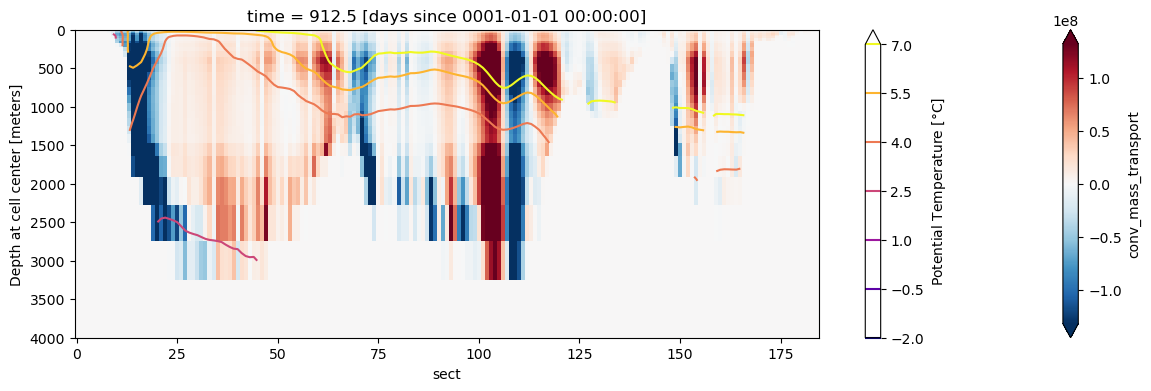

In [84]:
plt.figure(figsize=(15, 4))
Trp_east.isel(time=0)['conv_mass_transport'].plot(cmap='RdBu_r', yincrease=False, ylim=[4000,0], robust=True)
cs = T_east.isel(time=0).plot.contour(vmin=-2, vmax=7, cmap='plasma', yincrease=False, ylim=[4000,0])
plt.colorbar(cs, label=r"Potential Temperature [$\degree$C]")

## Diagnosing overturning streamfunctions in depth and density space

In [85]:
import xoverturning

In [86]:
names_z = {'x_center': 'sect',
         'layer': 'z_l',
         'interface': 'z_i'}

names_rho2 = {'x_center': 'sect',
              'layer': 'rho2_l',
              'interface': 'rho2_i'}

In [87]:
ovt_west = xoverturning.compfunc.compute_streamfunction(Trp_west, names_z, transport='conv_mass_transport', fromtop=True)

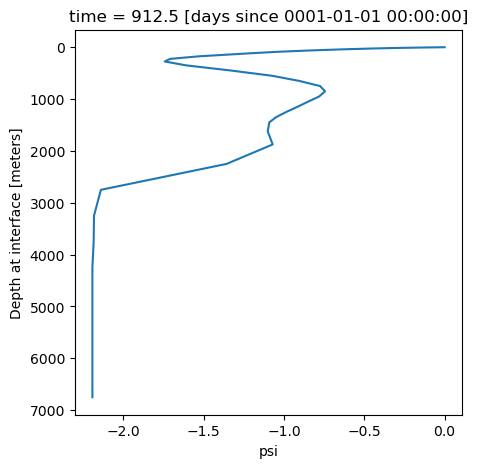

In [88]:
ovt_west.isel(time=0).plot(y='z_i', yincrease=False, figsize=[5,5])

In [89]:
ds_rho2 = xr.open_mfdataset(f"{dir_pp}/ocean_annual_rho2_d2/av/annual_5yr/*.nc", decode_times=False)

In [90]:
ds_rho2

<xarray.Dataset>
Dimensions:     (xh: 1440, yh: 1120, rho2_l: 35, rho2_i: 36, time: 1, nv: 2,
                 xq: 1441, yq: 1121)
Coordinates:
  * xh          (xh) float64 -298.6 -298.4 -298.1 -297.9 ... 60.7 60.93 61.16
  * yh          (yh) float64 -83.62 -83.54 -83.46 -83.39 ... 89.7 89.81 89.92
  * rho2_l      (rho2_l) float64 1.014e+03 1.028e+03 ... 1.037e+03 1.038e+03
  * rho2_i      (rho2_i) float64 999.5 1.028e+03 ... 1.037e+03 1.038e+03
  * time        (time) float64 912.5
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 -298.6 -298.4 -298.2 -298.0 ... 60.89 61.12 61.35
  * yq          (yq) float64 -83.64 -83.56 -83.48 -83.41 ... 89.78 89.89 90.0
Data variables:
    volcello    (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    thkcello    (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    umo         (time, rho2_l, yh, xq) float32 dask.array<chunksize=(1, 35, 1120, 1441), meta=np.ndarray>
    uhml        (time, rho2_l, yh, xq) float32 dask.array<chunksize=(1, 35, 1120, 1441), meta=np.ndarray>
    vmo         (time, rho2_l, yq, xh) float32 dask.array<chunksize=(1, 35, 1121, 1440), meta=np.ndarray>
    vhml        (time, rho2_l, yq, xh) float32 dask.array<chunksize=(1, 35, 1121, 1440), meta=np.ndarray>
    time_bnds   (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    average_T1  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:             CM4_piControl_c192_OM4p125_test_v6_proto2
    grid_type:         regular
    grid_tile:         N/A
    associated_files:  areacello: ocean_static_d2.nc
    history:           Tue Jul  6 20:17:04 2021: ncatted -O -a associated_fil...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....
    comment:           FMS time averaging, version 3.0, precision=double
    filename:          ocean_annual_rho2_d2.0001-0005.ann.nc

In [91]:
Trp_rho2_west = sectionate.convergent_transport(ds_rho2, iwest, jwest, symmetric, layer='rho2_l', interface='rho2_i')

In [92]:
ovt_rho2_west = xoverturning.compfunc.compute_streamfunction(Trp_rho2_west, names_rho2, transport='conv_mass_transport', fromtop=True)

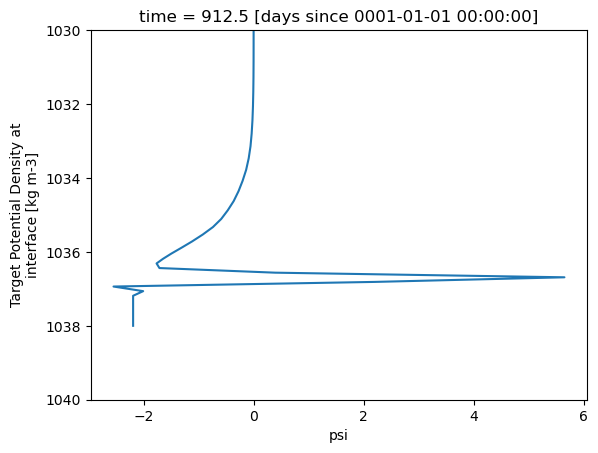

In [93]:
ovt_rho2_west.isel(time=0).plot(y='rho2_i', yincrease=False, ylim=[1040,1030])

In [94]:
Trp_rho2_east = sectionate.convergent_transport(ds_rho2, ieast, jeast, symmetric, layer='rho2_l', interface='rho2_i')

In [95]:
ovt_rho2_east = xoverturning.compfunc.compute_streamfunction(Trp_rho2_east, names_rho2, transport='conv_mass_transport', fromtop=True)

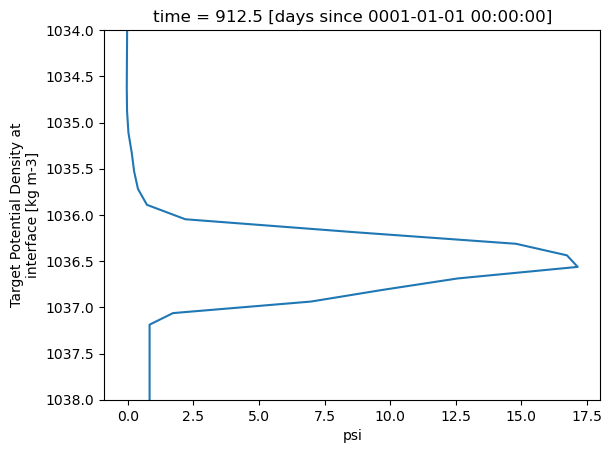

In [96]:
ovt_rho2_east.isel(time=0).plot(y='rho2_i', yincrease=False, ylim=[1038,1034])

In [97]:
np.isclose(ovt_west.isel(time=0).isel(z_i=-1).compute(), ovt_rho2_west.isel(time=0).isel(rho2_i=-1).compute(), rtol=1e-4)

True